# Análisis de Redes

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import plotly.express as px
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
import warnings
warnings.filterwarnings('ignore')

In [2]:
output_notebook()

Loading BokehJS ...

## Declaración de Funciones a utilizar

### Funciones para Resiliencias

In [3]:
def random_node(g): # select a random node from graph
    return [np.random.choice(g.nodes())]

def dismantle(g, function, **args): # incrementally removes node from a graph and computes size of connected components
    total_nodes = g.number_of_nodes()
    removed_nodes = []
    components = []
    while len(g.nodes())>1:
        n = function(g, **args)[0]
        g.remove_node(n)
        removed_nodes.append((len(removed_nodes)+1)/total_nodes)
        comps = list(nx.connected_components(g))
    
        g_size=0
        if len(comps)>0:
            g_size = max([len(c) for c in comps])/total_nodes
            components.append(g_size)
    
    return removed_nodes, components

def get_sorted_nodes(g, score, reverse=True): # Sort nodes
    
    nodes2 = score(g)
    if isinstance(nodes2, dict):
        nodes2 = [(k, v) for k, v in nodes2.items()]
    
    srt = sorted(nodes2, key=lambda x:x[1], reverse=True)
    return [x[0] for x in srt]

def plot_dismantle(x, y, color, title):
    fig, ax = plt.subplots(figsize=(10,6))
    plt.plot(x, y, color=color)
    plt.xlabel('Removed Nodes')
    plt.ylabel('Giant Component Size')
    plt.title(title, fontdict=dict(size=18))
    plt.show()

### Funciones para centralidades

Función para generar un dataframe en función de la medida de centralidad que se quiere revisar. Se sugiere utilizar usando un nombre nuevo de dataframe. Por ejemplo: degree_cent_df = fun_centrality_df(G, nx.degree_centrality)

In [4]:
def fun_centrality_df(g, centrality_measure):
  centrality = centrality_measure(g)
  nx.set_node_attributes(g, centrality, name=centrality_measure.__name__)
  centrality_df = pd.DataFrame(g.nodes(data=centrality_measure.__name__), columns=['node', centrality_measure.__name__])
  centrality_df = centrality_df.sort_values(by=centrality_measure.__name__, ascending=False)
  return centrality_df

Función para generar un gráfico de barras con el Top 20 de nodos acomodados conforme al dataframe creado anteriormente

In [5]:
def fun_plot_bar(df, color):  
  fig, ax = plt.subplots(figsize=(12,7))
  df.head(20).plot(kind='bar', x='node', y=df.columns[1], color=color, ax=ax)
  title = '%s - Top 20' % df.columns[1]
  plt.title(title, fontdict=dict(size=18))
  plt.show()

Función para generar un grafo (networkX). la entrada 'cmap' se tiene que utilizar conforme como cm.colormap (ej. cm.viridis). Referencia de colores en https://matplotlib.org/stable/tutorials/colors/colormaps.html

In [6]:
def fun_plot_network(g, centrality_measure, cmap):
  pos = nx.spring_layout(g, scale=10, center=(0,0), seed=92) 
  centrality = centrality_measure(g)

  # Se hace una iteración sobre los datos de cada nodo
  cent = np.fromiter(centrality.values(), float)

  # Se crea una variable donde se guardan las relaciones de cada nodo respecto al valor máximo de la centralidad de grado. Se realiza una multiplicación por 300 para que se pueda apreciar el tamaño en la gráfica
  sizes = cent / np.max(cent)*300

  # Se establece un mapa de color conforme a Matplotlib 
  colormap = cmap

  #Se crea otra variable para crear una barra de color para relacionar la centralidad de grado
  scalarmap = cm.ScalarMappable(cmap=colormap)
  scalarmap.set_array(cent)

  # Se genera el gráfico
  fig, ax = plt.subplots(figsize=(12, 7))
  plt.colorbar(scalarmap)
  nx.draw_networkx_nodes(g, pos, node_size=sizes, node_color=cent, edgecolors='k', cmap=colormap)
  nx.draw_networkx_edges(g, pos, edge_color='#DFDFDF', width=0.7)
  title = '%s - NetworkX' % centrality_measure.__name__
  plt.title(title, fontdict=dict(size=18))
  plt.show()

Función para resaltar nodos y comparar junto a una gráfica de barras (Top 10)

In [7]:
def fun_top10_plot(df, g, dim_color, bright_color):
  centrality_df_top10 = df.node.head(10).tolist()
  centrality_df_rest = df.loc[~df.node.isin(centrality_df_top10), 'node'].tolist()

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
  pos = nx.spring_layout(g, scale=10, center=(0,0), seed=92)
  df.head(10).plot(kind='bar', x='node', y=df.columns[1], color=bright_color, ax=axs[0])
  pc1 = nx.draw_networkx_nodes(g, pos, nodelist=centrality_df_rest, node_color=dim_color, node_size=20, alpha=0.7, ax=axs[1])
  pc2 = nx.draw_networkx_nodes(g, pos, nodelist=centrality_df_top10, node_color=bright_color, node_size=40, node_shape='h', ax=axs[1])
  pc2.zorder=3
  edges = nx.draw_networkx_edges(g, pos, width=0.3, edge_color='#DFDFDF', ax=axs[1])
  plt.suptitle(df.columns[1], fontsize=18)
  plt.tight_layout()
  plt.show()

## 4.- Crear un DataFrames en pandas para el archivo

### Se lee el archivo y se guarda en una lista

In [8]:
with open('email-enron-only.mtx') as f:
  f.readline()
  email_list = []
  for l in tqdm(f, colour='green'):
    l = l.split(' ')
    email_list.append(l)



622it [00:00, 879884.35it/s]


### Se genera el dataframe a partir de la lista creada

In [9]:
email_df = pd.DataFrame(email_list, columns=['id', 'target'])
email_df.head()

,id,target
0,72,1\n
1,3,2\n
2,19,2\n
3,20,2\n
4,27,2\n


### Se eliminan los caracteres '\n\ de la columna target y se cambian ambos dtypes a int (int64)

In [10]:
email_df['target'] = email_df['target'].map(lambda x: x.replace('\n', '')).astype(int)
email_df['id'] = email_df['id'].astype(int)
email_df.dtypes

id        int64
target    int64
dtype: object

## 5.- Construye una red no dirigida a partir de DataFrame. Utiliza NetworkX para tener una visualización adecuada de la red, puedes manipular el color y tamaño de nodos y arcos.

### Se crea el objeto NetworkX en la variable 'G'. Se grafica en Bokeh para tener una vista interactiva, en caso de querer hacer zoom y poder inspeccionar los nodos a detalle

In [11]:
G = nx.from_pandas_edgelist(email_df, 'id', 'target')
title = 'Email - Enron - Only'
hover_tooltips = [('Id', '@index')]
p = figure(tooltips=hover_tooltips,
            tools='pan, wheel_zoom, save, reset',
            active_scroll='wheel_zoom',
            x_range=Range1d(-12, 12),
            y_range=Range1d(-12, 12))

bokeh_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0,0), seed=92)
bokeh_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')
bokeh_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

p.renderers.append(bokeh_graph)

show(p)

## 6.- A partir de la red y usando NetworkX, responde las siguientes preguntas

### a) ¿Cuál es el nodo con el grado máximo? | b) ¿Cuál es el nodo con el grado mínimo?

El nodo con el grado máximo es el nodo 105 con 42 grados.
El nodo con el grado mínimo es el nodo 15, con solo un (1) grado

In [12]:
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

degree_df = pd.DataFrame(G.nodes(data='degree'), columns=['node', 'degree'])
degree_df = degree_df.sort_values(by='degree', ascending=False)
degree_df

,node,degree
30,105,42
45,17,29
73,95,23
9,48,20
14,132,19
...,...,...
1,1,1
136,92,1
104,42,1
139,98,1


In [13]:
degree_df_top20 = degree_df.head(20)
degree_df_top20['node'] = degree_df_top20['node'].astype(str)

fig = px.bar(degree_df_top20, x='node', y='degree', title='Top 20 nodes', color='degree', color_continuous_scale='blugrn')
fig.show()

In [14]:
degree_df_bt20 = degree_df.tail(20)
degree_df_bt20['node'] = degree_df_bt20['node'].astype(str)

fig = px.bar(degree_df_bt20, x='node', y='degree', title='Bottom 20 nodes', color='degree', color_continuous_scale='darkmint')
fig.show()

### c) ¿Cuál es el diámetro de la red?

In [15]:
print('El diámetro de la red es:\t', nx.diameter(G))

El diámetro de la red es:	 8


### d) ¿Cuál es la distancia promedio más corta?

In [16]:
print('La distancia promedio más corta es:\t', round(nx.average_shortest_path_length(G),2))

La distancia promedio más corta es:	 2.97


### e) ¿Es una red bipartita?

In [17]:
from networkx.algorithms import bipartite

if bipartite.is_bipartite(G) == True:
  print('La red es bipartita')
else:
  print('La red no es bipartita')


La red no es bipartita


## 7.- Resilencia

### a) ¿Cuántos y cuáles nodos hay que remover para que la red sea disconexa?

In [18]:
print('La cantidad de nodos que sería necesario remover para que la red sea disconexa es:\t', nx.node_connectivity(G))
print('El nodo a remover para que la conexión sea disconexa es:\t', nx.minimum_node_cut(G))


La cantidad de nodos que sería necesario remover para que la red sea disconexa es:	 1
El nodo a remover para que la conexión sea disconexa es:	 {72}


### b) ¿Cuántos y cuáles arcos hay que remover para que la red sea disconexa?

In [19]:
print('La cantidad de arcos que sería necesario remover para que la red sea disconexa es:\t', nx.edge_connectivity(G))
print('El arco a remover para que la conexión sea disconexa es:\t', nx.minimum_edge_cut(G))

La cantidad de arcos que sería necesario remover para que la red sea disconexa es:	 1
El arco a remover para que la conexión sea disconexa es:	 {(130, 98)}


## 8.- Una vez encontrados los nodos y arcos del paso anterior, identifícalos con un color diferente en la visualización de la red.

Text(0.5, 1.0, 'Node cut: 72 | Edge cut: (130, 98)')

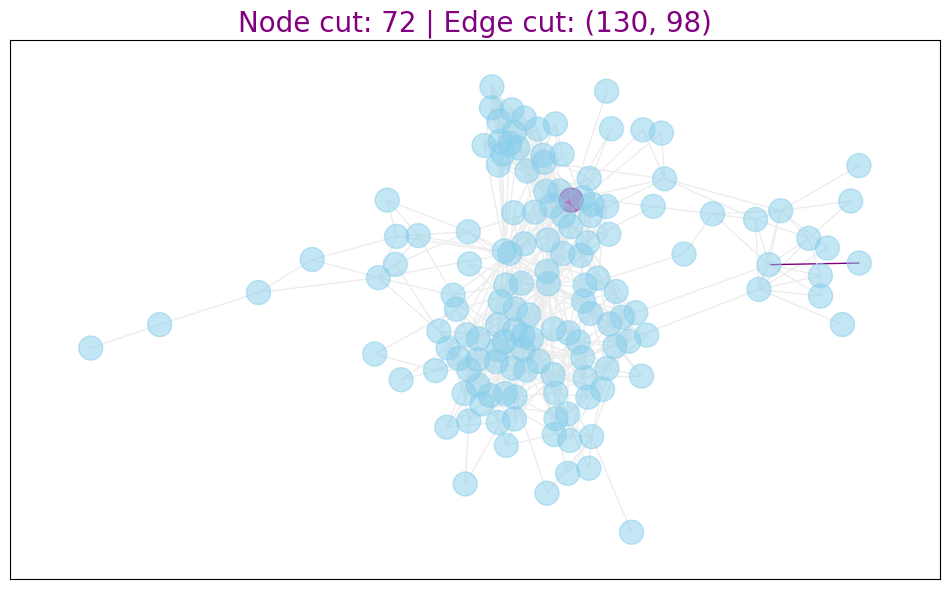

In [20]:
node_cut = nx.minimum_node_cut(G)
edge_cut = nx.minimum_edge_cut(G)

node_colors = 'skyblue'
edge_colors = '#EDEDED'
nx.set_node_attributes(G, node_colors, name='color')
nx.set_node_attributes(G, {next(iter(node_cut)):{'color':'purple'}})
nx.set_edge_attributes(G, edge_colors, name='edge_color')
nx.set_edge_attributes(G, {next(iter(edge_cut)): {'edge_color':'purple'}})


g_nodes_colors = nx.get_node_attributes(G, 'color').values()
g_edges_colors = nx.get_edge_attributes(G, 'edge_color').values()

fig, ax = plt.subplots(figsize=(12, 7))
pos = nx.spring_layout(G, scale=10, center=(0,0), seed=92)
nx.draw_networkx_nodes(G, pos, node_color=g_nodes_colors, alpha=0.5)
nx.draw_networkx_edges(G, pos, edge_color=g_edges_colors)
title = 'Node cut: %d | Edge cut: %r' % (next(iter(node_cut)), next(iter(edge_cut)))
plt.title(title, fontdict=dict(size=20), color='purple')

## 9.- Calcula y visualiza las centralidades de la red

### Centralidad de Grado

In [21]:
deg_cent_df = fun_centrality_df(G, nx.degree_centrality)
deg_cent_df.head()



,node,degree_centrality
30,105,0.295775
45,17,0.204225
73,95,0.161972
9,48,0.140845
14,132,0.133803


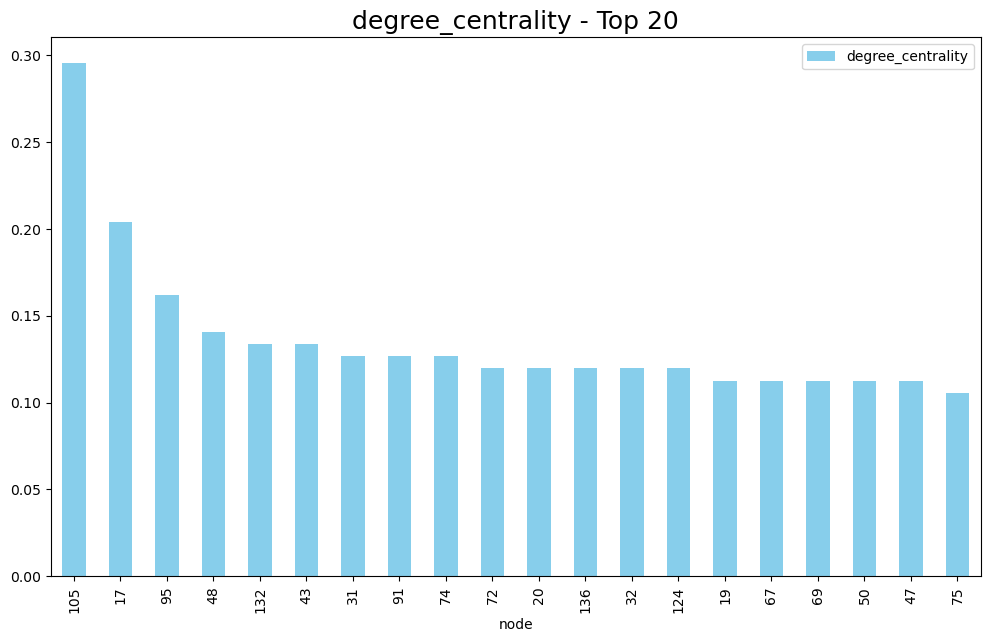

In [22]:
fun_plot_bar(deg_cent_df, color='skyblue')

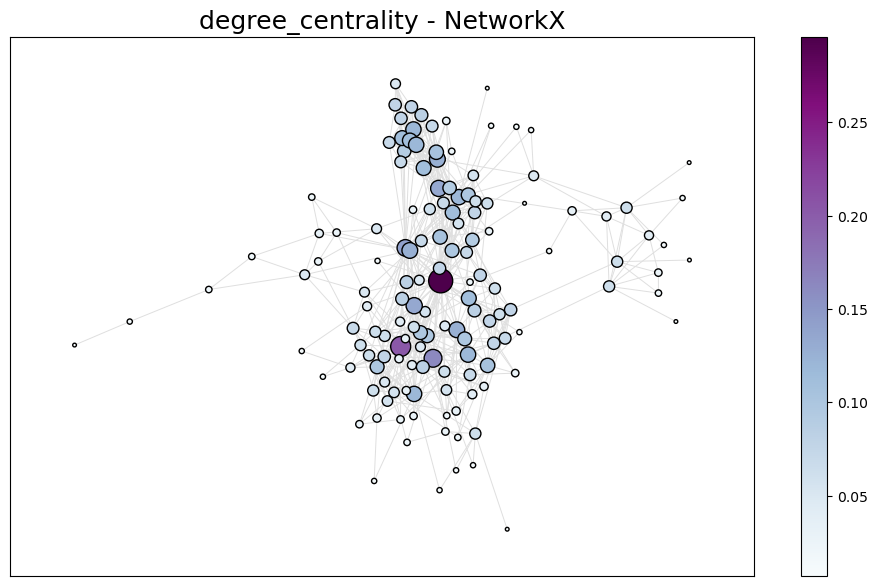

In [23]:
fun_plot_network(G, nx.degree_centrality, cm.BuPu)

### Centralidad de intermediación

In [24]:
bet_cent_df = fun_centrality_df(G, nx.betweenness_centrality)
bet_cent_df.head()

,node,betweenness_centrality
30,105,0.196135
45,17,0.102705
9,48,0.098005
43,91,0.091789
52,32,0.084816


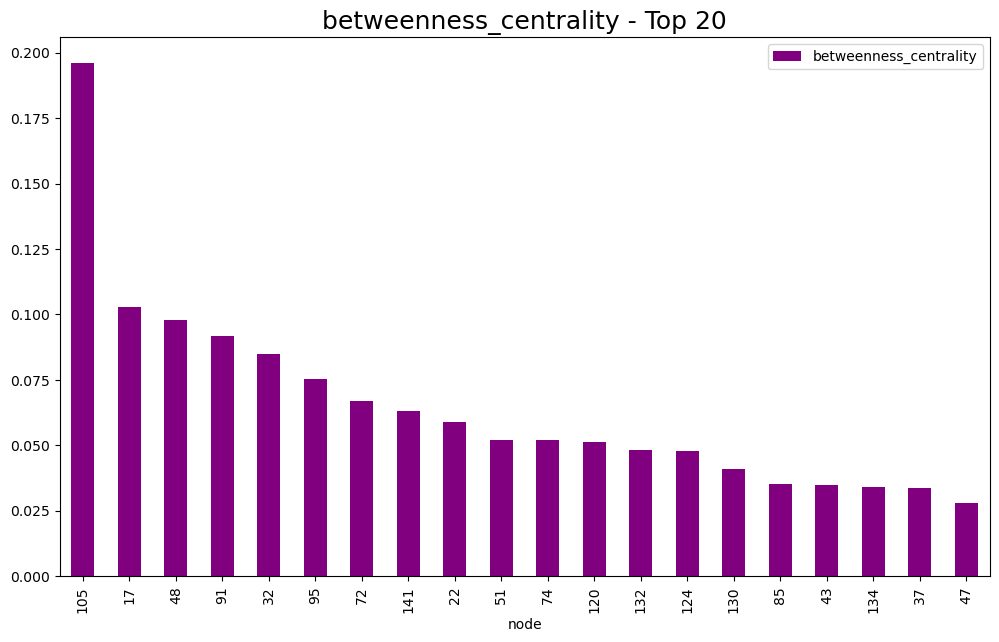

In [25]:
fun_plot_bar(bet_cent_df, 'purple')

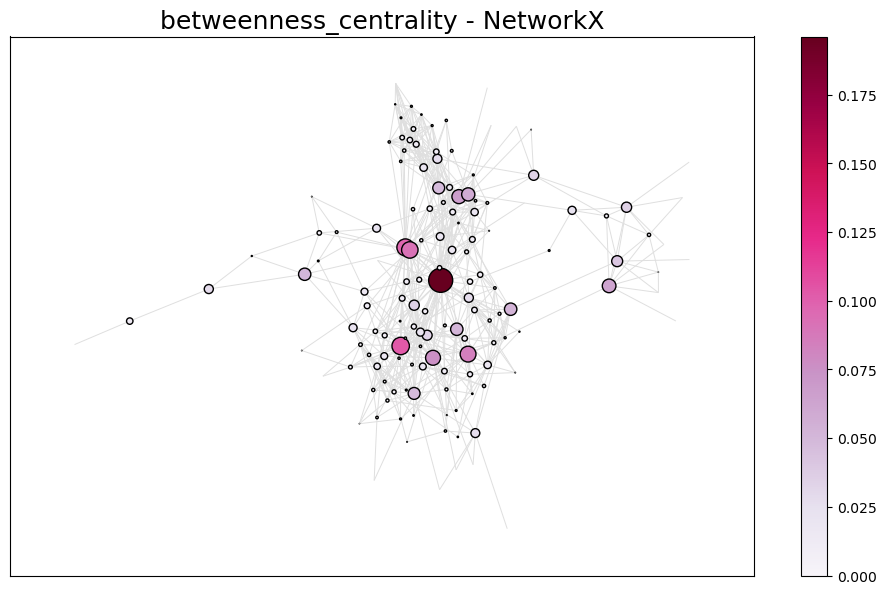

In [26]:
fun_plot_network(G, nx.betweenness_centrality, cm.PuRd)

### Centralidad de Cercanía

In [27]:
clo_cent_df = fun_centrality_df(G, nx.closeness_centrality)
clo_cent_df.head()

,node,closeness_centrality
30,105,0.500000
45,17,0.467105
48,37,0.436923
73,95,0.436923
35,74,0.436923


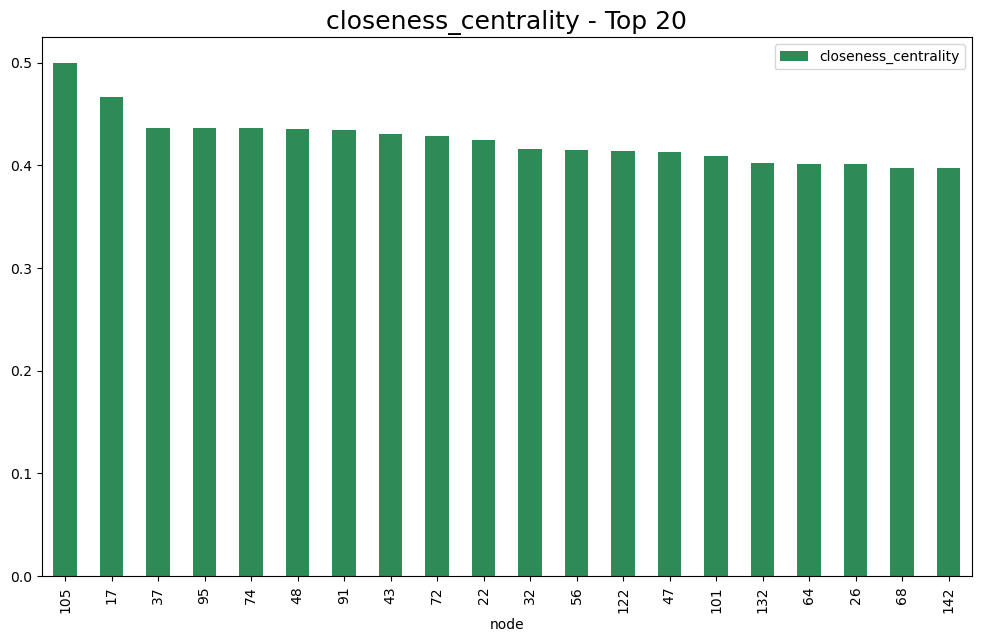

In [28]:
fun_plot_bar(clo_cent_df, 'seagreen')

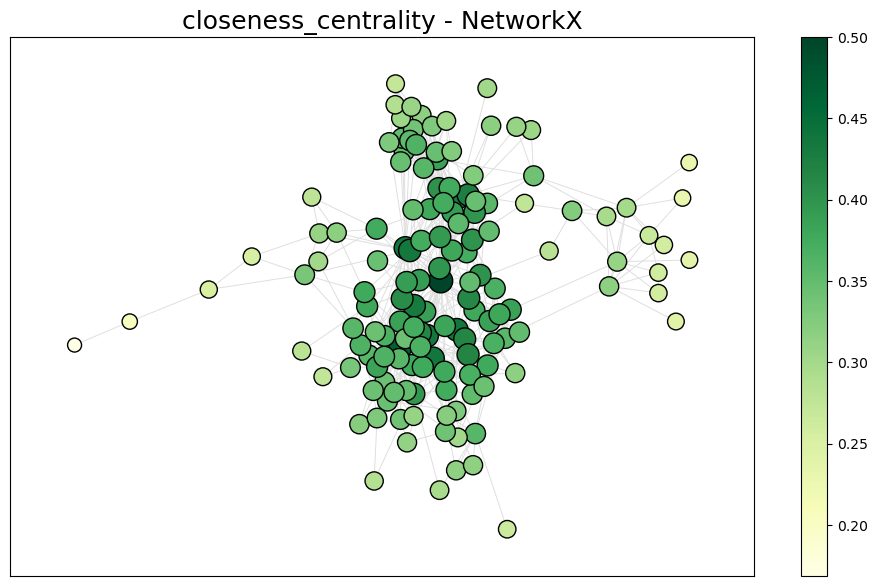

In [29]:
fun_plot_network(G, nx.closeness_centrality, cm.YlGn)

## 10.- Muestra con un color diferente en la red a los 10 nodos más importantes para cada centralidad

### Centralidad de Grado

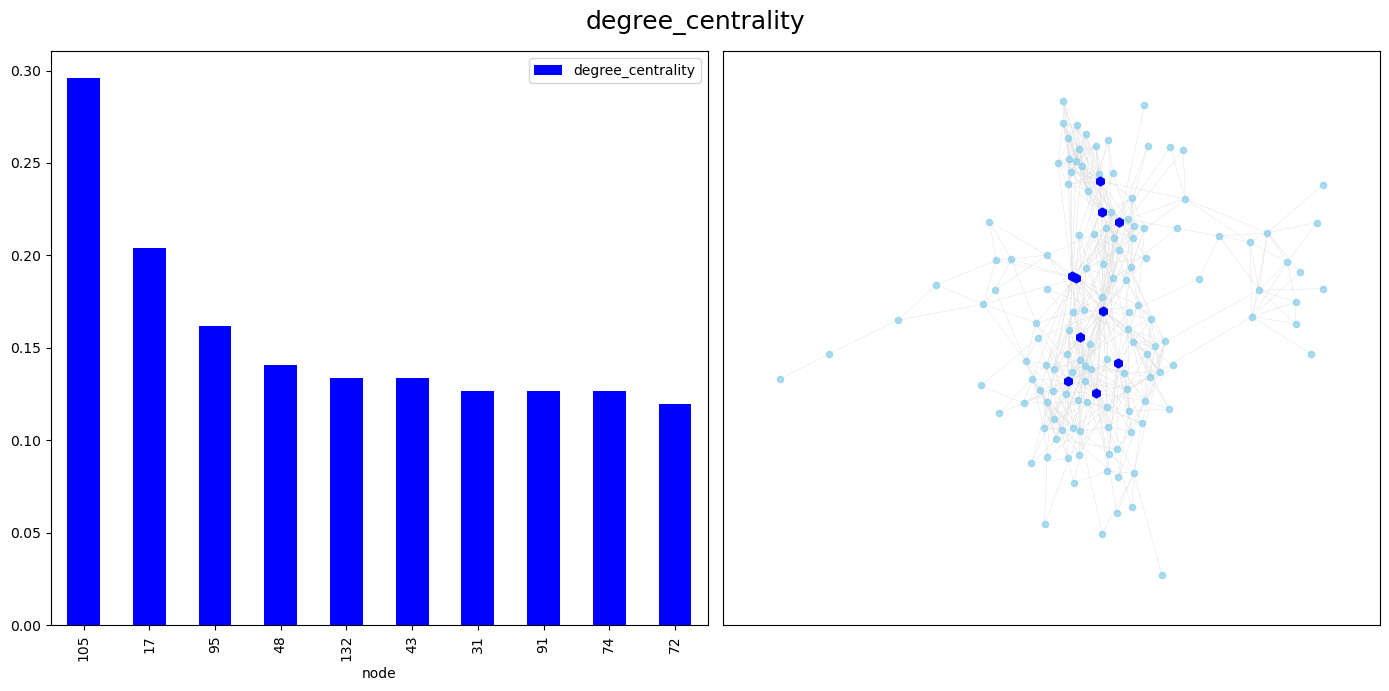

In [30]:
fun_top10_plot(deg_cent_df, G, 'skyblue', 'blue')

### Centralidad de Intermediación

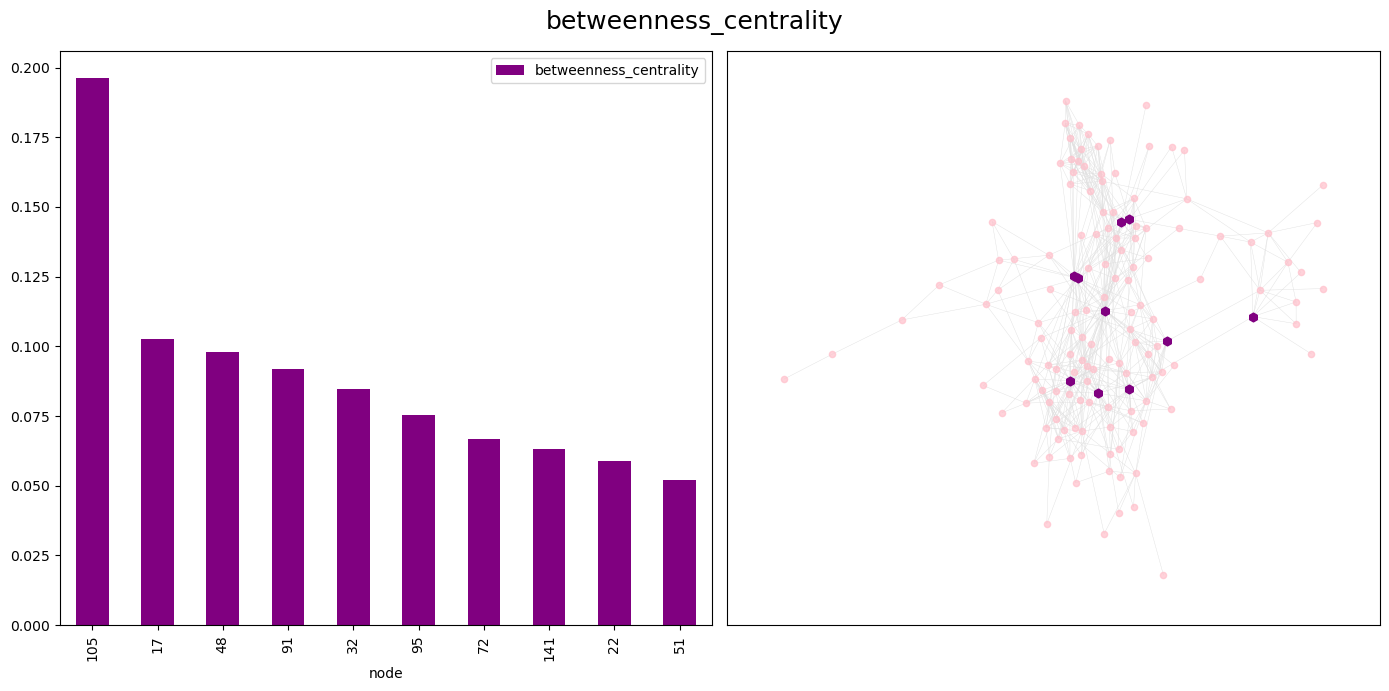

In [31]:
fun_top10_plot(bet_cent_df, G, 'pink', 'purple')

### Centralidad de Cercanía

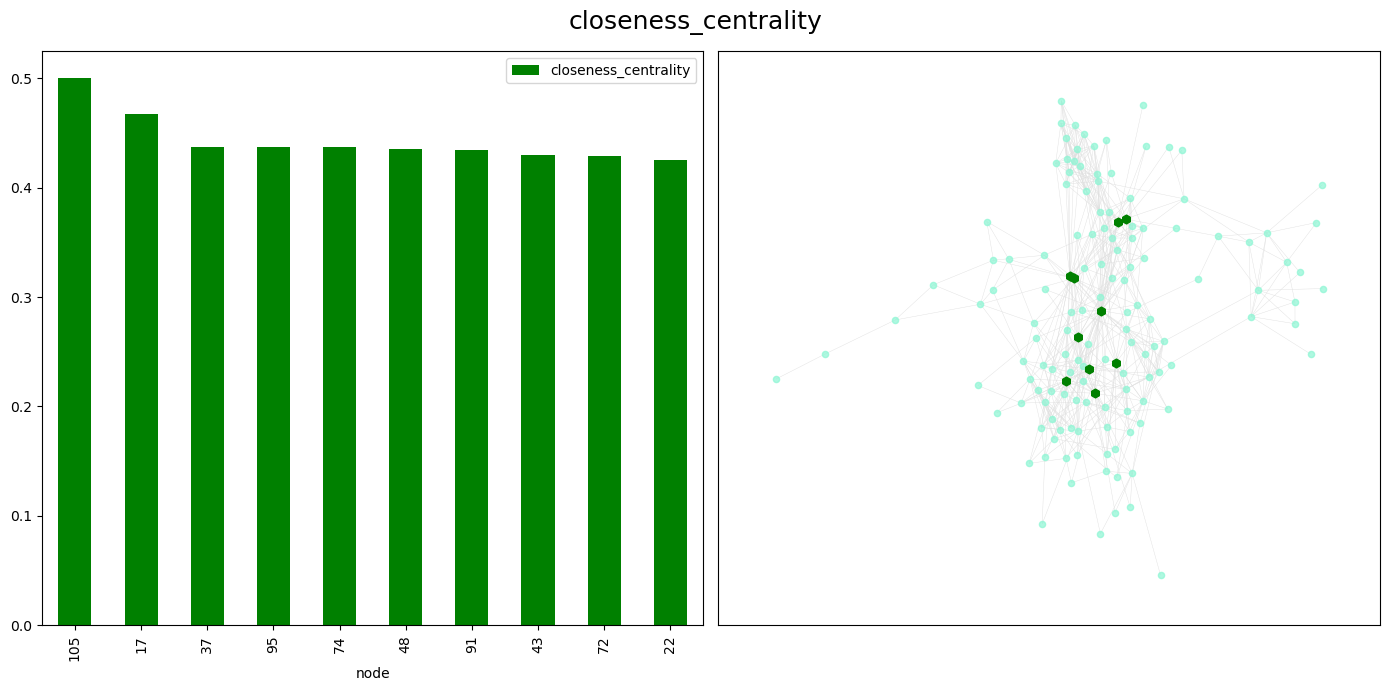

In [32]:
fun_top10_plot(clo_cent_df, G, '#8CF6D4', 'green')

## 11.- Crea una red dirigida - PageRank

In [33]:
pagerank_df = fun_centrality_df(G, nx.pagerank)
pagerank_df.head()

,node,pagerank
30,105,0.028965
45,17,0.021343
73,95,0.017772
43,91,0.014448
39,124,0.013845


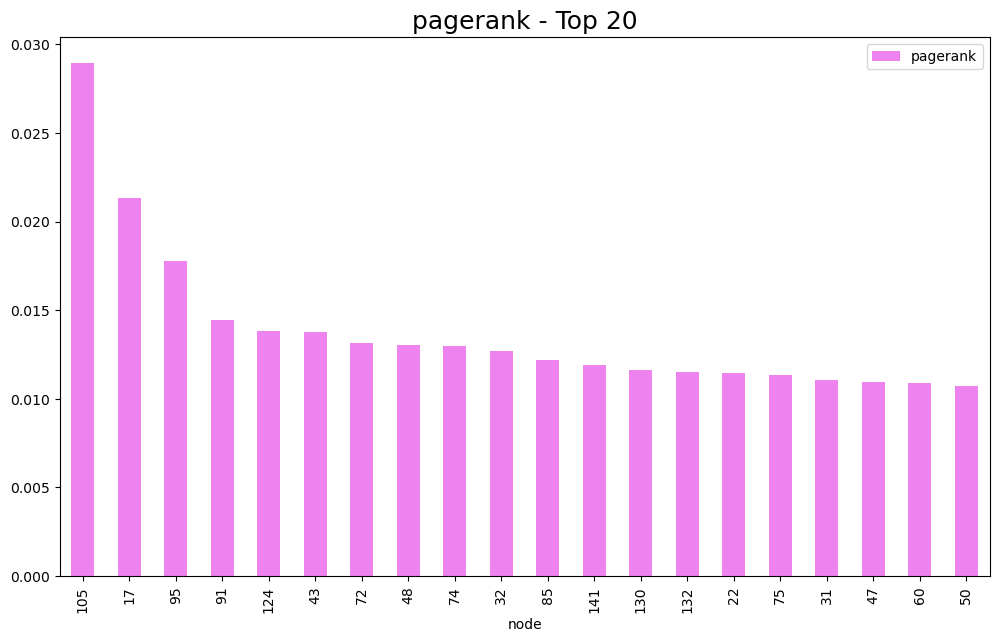

In [34]:
fun_plot_bar(pagerank_df, 'violet')

In [35]:
df = pd.merge(left=email_df, right=pagerank_df, how='left', left_on='id', right_on='node')
df = df.sort_values(by='pagerank', ascending=False)
df.head()


,id,target,node,pagerank
311,105,44,105,0.028965
457,105,74,105,0.028965
434,105,68,105,0.028965
412,105,64,105,0.028965
406,105,61,105,0.028965


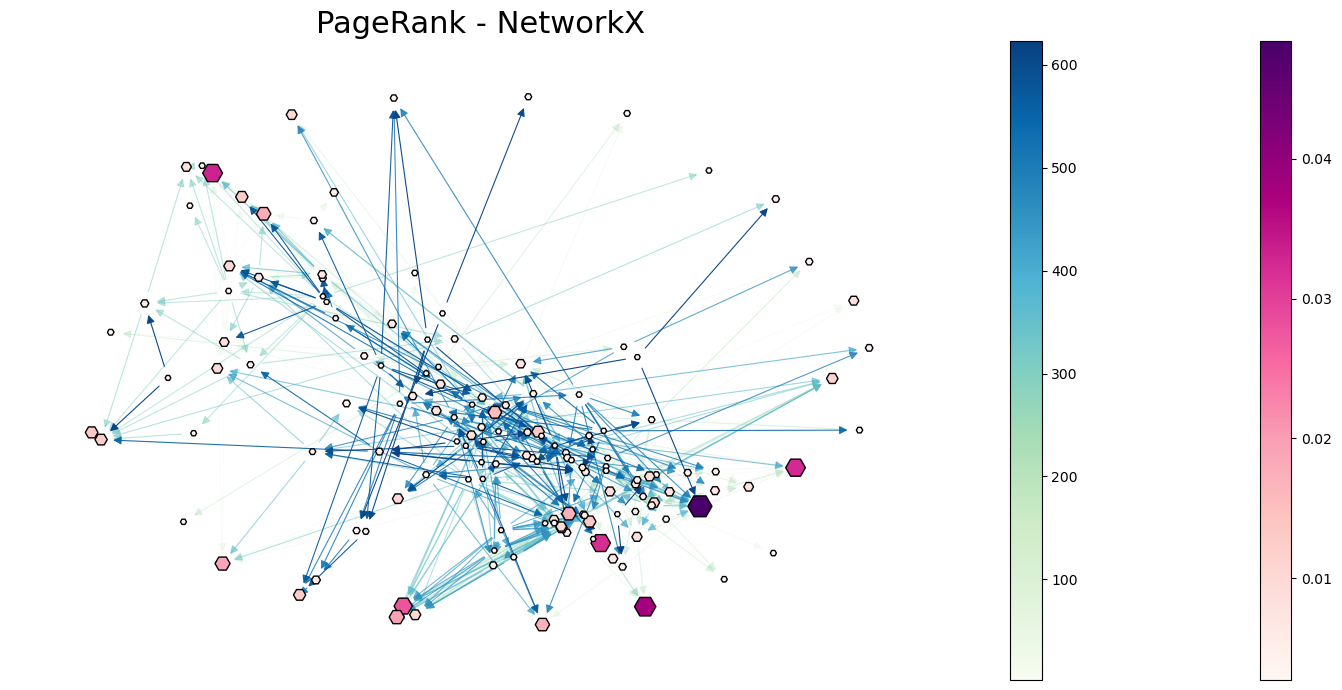

In [36]:
g = nx.from_pandas_edgelist(df=df, source='id', target='target', create_using=nx.DiGraph())

pos_a = nx.spring_layout(g, scale=10, center=(0,0))

# Se hace una iteración sobre los datos de cada nodo
pagerank = nx.pagerank(g)
pagerank_cent = np.fromiter(pagerank.values(), float)


# Se crea una variable donde se guardan las relaciones de cada nodo respecto al valor máximo de la centralidad de grado. Se realiza una multiplicación por 300 para que se pueda apreciar el tamaño en la gráfica
sizes = pagerank_cent / np.max(pagerank_cent)*300

# Se establece un mapa de color conforme a Matplotlib (https://matplotlib.org/stable/tutorials/colors/colormaps.html)
colormap = cm.RdPu
edge_cmap = cm.GnBu

# Se crea otra variable para crear una barra de color para relacionar la centralidad de grado
scalarmap = cm.ScalarMappable(cmap=colormap)
scalarmap.set_array(pagerank_cent)

# Se establece una escala para referenciar colores de cmap conforme al número de arcos
M = G.number_of_edges()
edge_colors = range(2, M+2)
edge_alphas = [(5+i)/(M+4) for i in range(M)]

# Se establecen los primeros parámetros del gráfico
fig, ax = plt.subplots(figsize=(15, 7))
nodes = nx.draw_networkx_nodes(g, pos_a, node_size=sizes, node_color=pagerank_cent, edgecolors='k', node_shape='H', cmap=colormap, ax=ax)
edges = nx.draw_networkx_edges(g, pos_a, edge_color=edge_colors, edge_cmap=edge_cmap, width=0.8, arrowstyle='-|>', arrowsize=12, ax=ax)

# Se establecen parámetros de alphas para los arcos
for i in range(M):
  edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=edge_cmap)
pc.set_array(edge_colors)

# Se genera el gráfico
ax = plt.gca()
ax.set_axis_off()
plt.colorbar(scalarmap, ax=ax)
plt.colorbar(pc, ax=ax)
plt.title('PageRank - NetworkX', fontdict=dict(size=22))
plt.tight_layout()
plt.show()

## 12.- Conclusiones

### a) Total de empleados, total de interacciones por correo electrónico

In [37]:
print('Total de Empleados:\t', G.number_of_nodes())
print('\nTotal de Interacciones:\t', G.number_of_edges())

Total de Empleados:	 143

Total de Interacciones:	 622


### b) Quién tiene el máximo grado, quien el mínimo, y que significa

Como se observa en las gráficas debajo, el mayor grado lo tiene el nodo 105 y el menor grado lo tienen los nodos 80, 63, 1, 92, 42 98 y 15. Esto quiere decir que el grado 105 tiene el máximo número de arcos adyacentes, mientras que los últimos los menos

In [38]:
fig = px.bar(degree_df_top20, x='node', y='degree', title='Top 20 nodes', color='degree', color_continuous_scale='blugrn')
fig.show()

In [39]:
fig = px.bar(degree_df_bt20, x='node', y='degree', title='Bottom 20 nodes', color='degree', color_continuous_scale='darkmint')
fig.show()

### c) ¿Cuál es el diámetro de la red y qué significa?

El diámetro de la red es 8. Esto quiere decir que la distancia más corta entre los dos nodos más distantes en la red

In [40]:
print('El diámetro de la red es:\t', nx.diameter(G))

El diámetro de la red es:	 8


### d) ¿Cuál es el promedio de los caminos más corto y que significa?

El promedio de los caminos más cortos significa que, entre todos los caminos más cortos entre dos nodos, este número nos representa el promedio de la suma de todos ellos

In [41]:
print('La distancia promedio más corta es:\t', round(nx.average_shortest_path_length(G),2))

La distancia promedio más corta es:	 2.97


### e) ¿La red es robusta? ¿Cómo reacciona el sistema ante fallas o ataques?

La red no es robusta. Como se observa debajo, en primera instancia para desconectar la red solo se necesita eliminar un nodo o un solo arco. En cuanto a ataques se refiere, revisando la centralidad de intermediación, con apenas una pequeña cantidad de nodos de la red la desconexión es masiva en toda la red

In [42]:
print('La cantidad de nodos que sería necesario remover para que la red sea disconexa es:\t', nx.node_connectivity(G))
print('El nodo a remover para que la conexión sea disconexa es:\t', nx.minimum_node_cut(G))
print('+-+-+-+-+-+-+-+')
print('La cantidad de arcos que sería necesario remover para que la red sea disconexa es:\t', nx.edge_connectivity(G))
print('El arco a remover para que la conexión sea disconexa es:\t', nx.minimum_edge_cut(G))


La cantidad de nodos que sería necesario remover para que la red sea disconexa es:	 1
El nodo a remover para que la conexión sea disconexa es:	 {72}
+-+-+-+-+-+-+-+
La cantidad de arcos que sería necesario remover para que la red sea disconexa es:	 1
El arco a remover para que la conexión sea disconexa es:	 {(130, 98)}


In [43]:
degs = list(dict(G.degree()).values())

In [44]:
def molloy_reed(degrees):
    return (np.mean(degrees)*(np.mean(degrees)+1))/np.mean(degrees)

def breakdown_threshold(degrees):
    K = molloy_reed(degrees)
    return 1 - (1/(K-1))

In [45]:
molloy_reed(degs)

9.6993006993007

In [46]:
breakdown_threshold(degs)

0.885048231511254

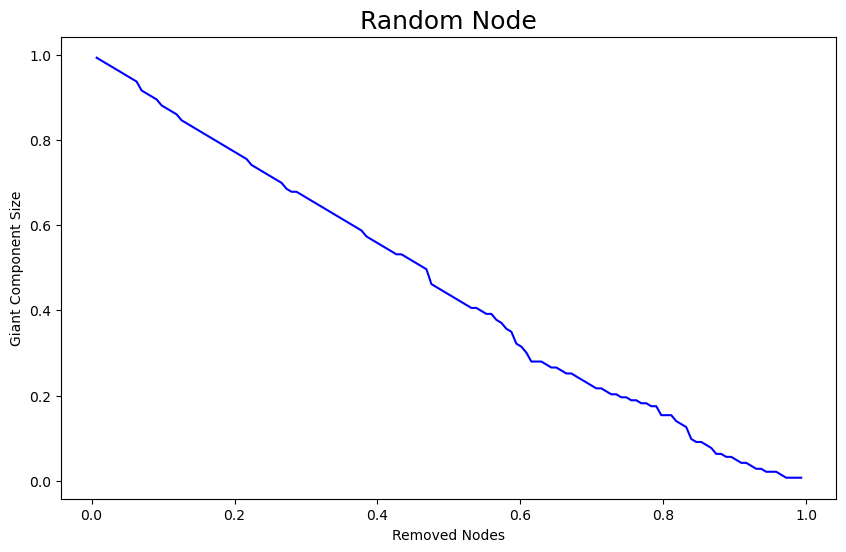

In [47]:
h = G.copy()
rn, comps = dismantle(h, random_node)
plot_dismantle(rn, comps, 'blue', 'Random Node')


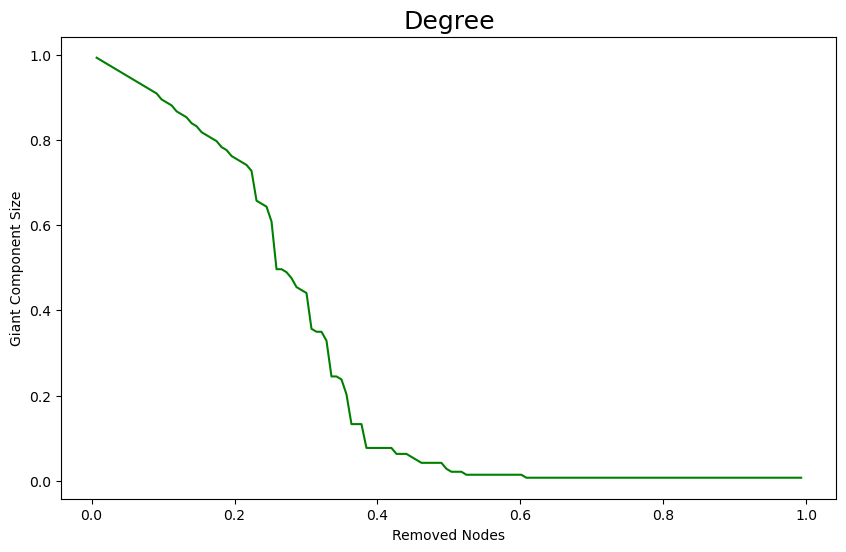

In [48]:
h2 = G.copy()
rn2, comps2 = dismantle(h2, get_sorted_nodes, score=nx.degree)
plot_dismantle(rn2, comps2, 'green', 'Degree')

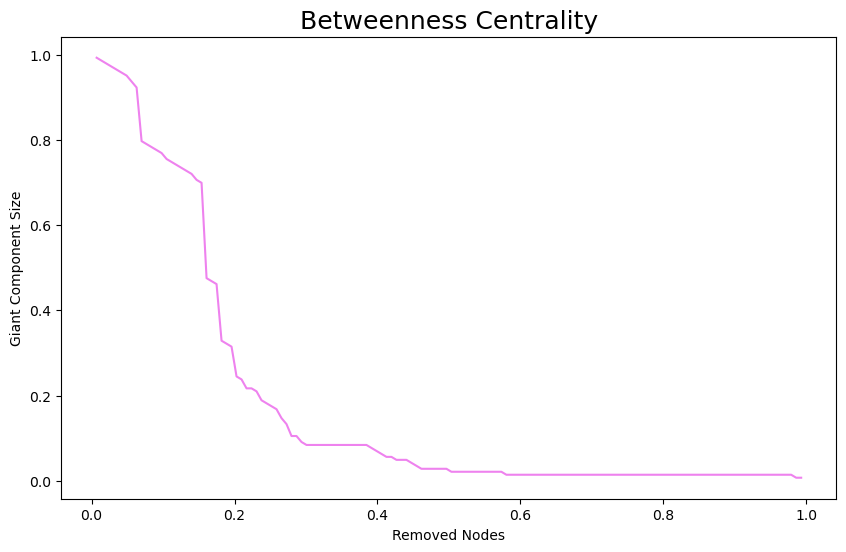

In [49]:
h3 = G.copy()
rn3, comps3 = dismantle(h3, get_sorted_nodes, score=nx.betweenness_centrality)
plot_dismantle(rn3, comps3, 'violet', 'Betweenness Centrality')

### f) Tomando en cuenta las tres medidas de centralidad, ¿cuáles son los nodos más importantes?

Como se observa en las gráficas debajo, los nodos más repetidos en el Top 20 de cada centralidad son: 17, 105, 47, 43, 32, 72, 74, 91, 95, 132, 48

Es importante recalcar que, conforme a la gráfica comparativa, el nodo 105 siempre aparece en primer lugar, mientras que el nodo 17 siempre aparece en segundo lugar

Text(0.5, 0.98, 'Centralities Comparison')

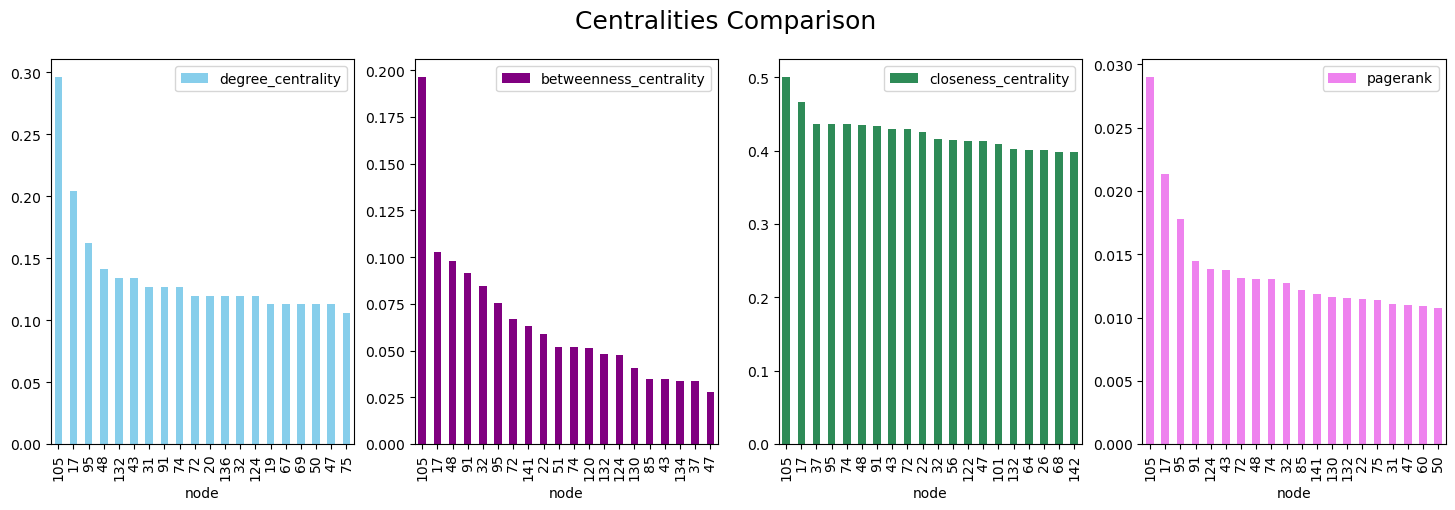

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))
deg_cent_df.head(20).plot(kind='bar', x='node', y=deg_cent_df.columns[1], color='skyblue', ax=axs[0])
bet_cent_df.head(20).plot(kind='bar', x='node', y=bet_cent_df.columns[1], color='purple', ax=axs[1])
clo_cent_df.head(20).plot(kind='bar', x='node', y=clo_cent_df.columns[1], color='seagreen', ax=axs[2])
pagerank_df.head(20).plot(kind='bar', x='node', y=pagerank_df.columns[1], color='violet', ax=axs[3])
plt.suptitle('Centralities Comparison', fontsize=18)

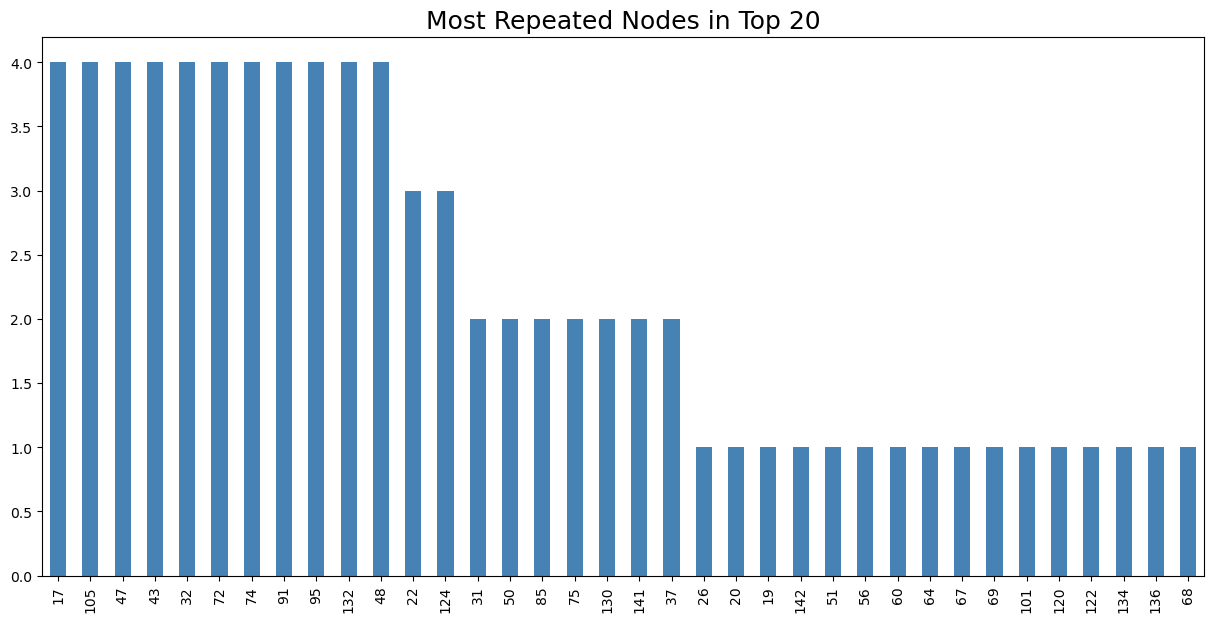

In [51]:
df_counts = pd.concat([deg_cent_df.head(20), bet_cent_df.head(20), clo_cent_df.head(20), pagerank_df.head(20)])
df_counts = df_counts.sort_values(by='node', ascending=False)
fig, ax = plt.subplots(figsize=(15,7))
ax = df_counts.node.value_counts().plot(kind='bar', color='steelblue')
plt.title('Most Repeated Nodes in Top 20', fontdict=dict(size=18))
plt.show()

### g) Según el PageRank, ¿quién es el nodo más importante? Y en base a que es su importancia

Como se observa en la primera gráfica debajo, el nodo más importante es el 105 dada la probabilidad de que las comunicaciones por correo pasen a través de ese nodo. En el grafo posterior, se observa ese nodo en un color morado muy obscuro que, conforme a la escala de color, indica su score de PageRank y se osbervan varias conexiones dirigadas hacia ese nodo

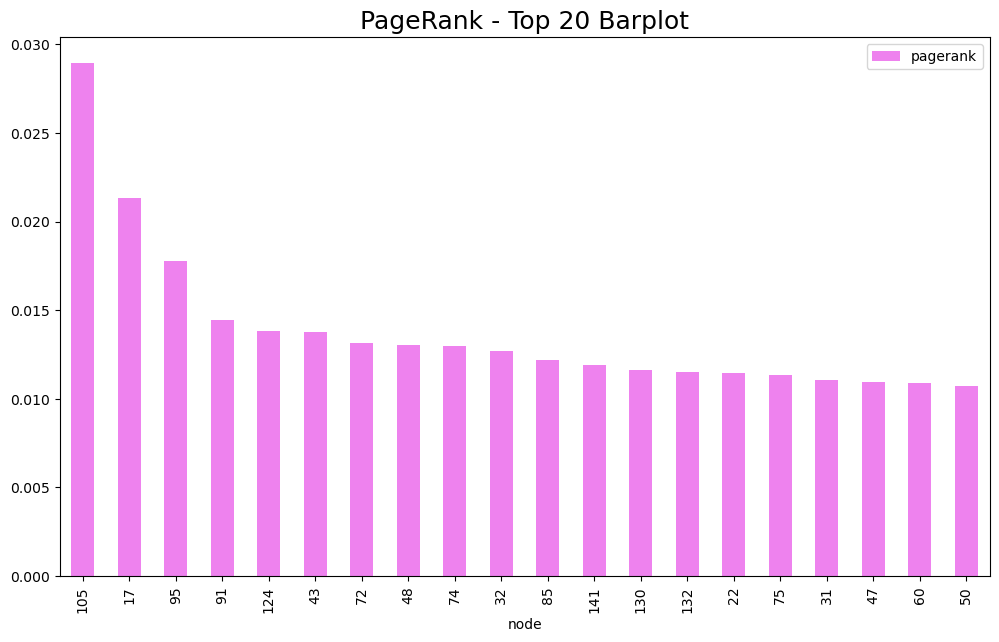

In [52]:
fig, ax = plt.subplots(figsize=(12,7))
pagerank_df.head(20).plot(kind='bar', x='node', y='pagerank', color='violet', ax=ax)
plt.title('PageRank - Top 20 Barplot', fontdict=dict(size=18))
plt.show()

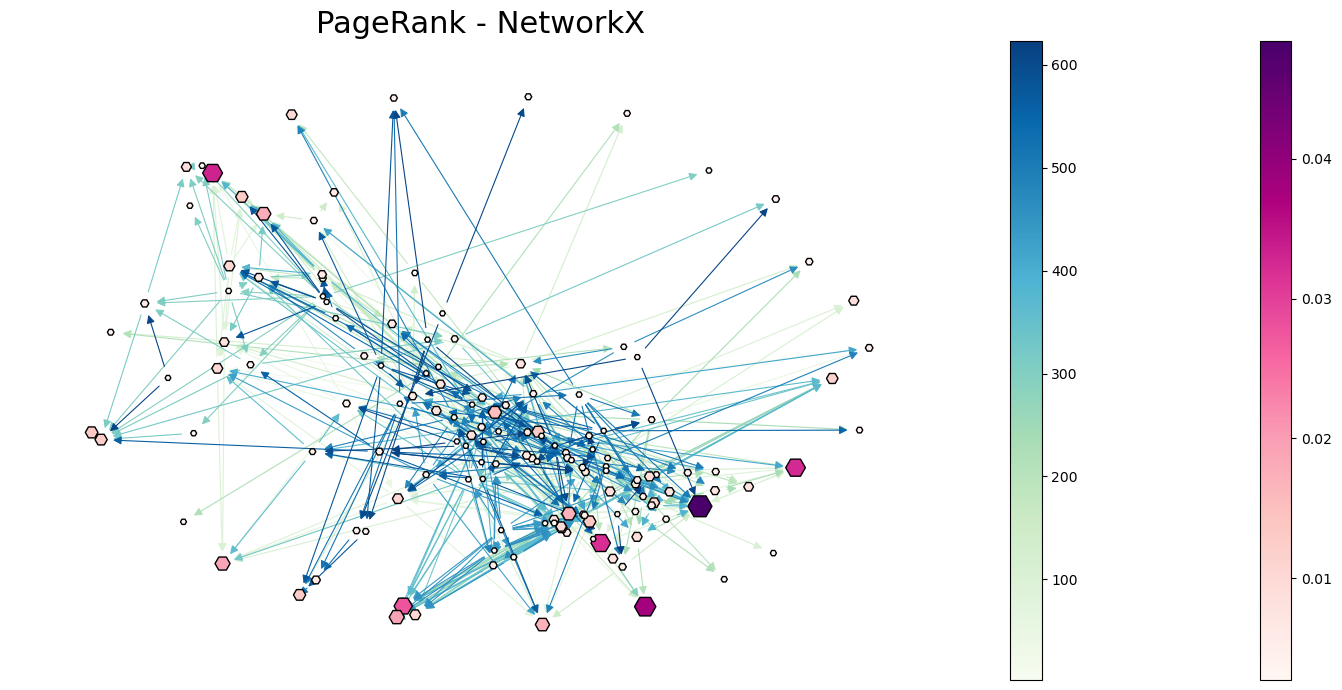

In [53]:
fig, ax = plt.subplots(figsize=(15, 7))
nodes = nx.draw_networkx_nodes(g, pos_a, node_size=sizes, node_color=pagerank_cent, edgecolors='k', node_shape='H', cmap=colormap, ax=ax)
edges = nx.draw_networkx_edges(g, pos_a, edge_color=edge_colors, edge_cmap=edge_cmap, width=0.8, arrowstyle='-|>', arrowsize=12, ax=ax)
ax = plt.gca()
ax.set_axis_off()
plt.colorbar(scalarmap, ax=ax)
plt.colorbar(pc, ax=ax)
plt.title('PageRank - NetworkX', fontdict=dict(size=22))
plt.tight_layout()
plt.show()
